# Phần preprocessing

Thư viện

In [1]:
import os
import numpy as np
import pandas as pd

Định nghĩa các thông số

In [ ]:
step = 32 # Time_step là số lượng đủ để đưa vào predict 
X = [] # Data sau cùng
Y = [] # Label (1 là tục, 0 là không tục)

Lấy data

In [4]:
list_folder_name = os.listdir('DATA')
min_line = 1e9
list_len_frame = []

for folder in list_folder_name:
    list_file_error = []
    path_folder_parent = os.path.join('DATA', folder)
    
    path_folder_tuc = os.path.join(path_folder_parent, 'DATA_TUC')
    path_folder_khong_tuc = os.path.join(path_folder_parent, 'DATA_KHONG_TUC')

    quantity_file = 0
    # Data tục
    for file in os.listdir(path_folder_tuc):
        if file.endswith('.csv'):
            quantity_file += 1
            path_file_csv = os.path.join(path_folder_tuc, file)
            
            try:
                data = pd.read_csv(path_file_csv)
                data = data.to_numpy()
                if(data.shape[0] < step):
                    n = step // data.shape[0]

                    data = np.concatenate([data] * (n + 1))
                list_len_frame.append([data.shape[0], path_file_csv])
                data = data.reshape(-1, 40, 2)
                
                for i in range(step, data.shape[0]):
                    X.append(data[i - step: i, :])
                    Y.append(1)
            except:
                list_file_error.append(path_file_csv)
                
    # Data không tục
    for file in os.listdir(path_folder_khong_tuc):
        if file.endswith('.csv'):
            quantity_file += 1
            path_file_csv = os.path.join(path_folder_khong_tuc, file)
            
            try:
                data = pd.read_csv(path_file_csv)
                data = data.to_numpy()
                if(data.shape[0] < step):
                    n = step // data.shape[0]

                    data = np.concatenate([data] * (n + 1))

                list_len_frame.append([data.shape[0], path_file_csv])
                data = data.reshape(-1, 40, 2)
                
                for i in range(step, data.shape[0]):
                    X.append(data[i - step: i, :])
                    Y.append(0)
            except:
                list_file_error.append(path_file_csv)
    
    print('Đã lấy xong dữ liệu của: ' + folder)
    print('Tổng số file lỗi là: ' + str(len(list_file_error)) + '/' + str(quantity_file))
    print('File lỗi: ', 'không có' if list_file_error == [] else list_file_error)
    print('==============================================================================================================')
list_len_frame.sort(key= lambda x : x[0])
print('\t\t\t\t\t Đã lấy xong dữ liệu tất cả')
print('Min frame là: ', list_len_frame[0])
print('File min frame: ' + list_len_frame[0][1])
print(list_len_frame)

Đã lấy xong dữ liệu của: 01
Tổng số file lỗi là: 0/0
File lỗi:  không có
Đã lấy xong dữ liệu của: 02
Tổng số file lỗi là: 0/170
File lỗi:  không có
Đã lấy xong dữ liệu của: 03
Tổng số file lỗi là: 0/170
File lỗi:  không có
Đã lấy xong dữ liệu của: 04
Tổng số file lỗi là: 0/170
File lỗi:  không có
Đã lấy xong dữ liệu của: 05
Tổng số file lỗi là: 0/65
File lỗi:  không có
Đã lấy xong dữ liệu của: 06
Tổng số file lỗi là: 0/0
File lỗi:  không có
Đã lấy xong dữ liệu của: 07
Tổng số file lỗi là: 0/86
File lỗi:  không có
Đã lấy xong dữ liệu của: 08
Tổng số file lỗi là: 0/170
File lỗi:  không có
Đã lấy xong dữ liệu của: 09
Tổng số file lỗi là: 0/0
File lỗi:  không có
Đã lấy xong dữ liệu của: 10
Tổng số file lỗi là: 0/0
File lỗi:  không có
Đã lấy xong dữ liệu của: 11
Tổng số file lỗi là: 0/0
File lỗi:  không có
Đã lấy xong dữ liệu của: 12
Tổng số file lỗi là: 0/0
File lỗi:  không có
Đã lấy xong dữ liệu của: 13
Tổng số file lỗi là: 0/0
File lỗi:  không có
Đã lấy xong dữ liệu của: 14
Tổng số file 

Chuyển về numpy

In [5]:
X = np.array(X)
Y = np.array(Y)
Y = Y.reshape(-1, 1)
print(X.shape, Y.shape)

(101074, 32, 40, 2) (101074, 1)


Lưu để tiện dùng sau

In [7]:
import pickle
pickle.dump(X, open('X.pkl', 'wb'))
pickle.dump(Y, open('Y.pkl', 'wb'))

# Training model

Chia dữ liệu

In [8]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.2)


Tạo model

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import F1Score

In [10]:
class TemporalBlock(tf.keras.layers.Layer):
    def __init__(self, n_inputs, n_outputs, kernel_size, dilation_rate, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()

        self.conv1 = layers.Conv1D(filters=n_outputs, kernel_size=kernel_size,
                                   padding=padding, dilation_rate=dilation_rate,
                                   kernel_initializer='he_normal')
        self.bn1 = layers.BatchNormalization()
        self.relu1 = layers.ReLU()
        self.dropout1 = layers.Dropout(dropout)

        self.conv2 = layers.Conv1D(filters=n_outputs, kernel_size=kernel_size,
                                   padding=padding, dilation_rate=dilation_rate,
                                   kernel_initializer='he_normal')
        self.bn2 = layers.BatchNormalization()
        self.relu2 = layers.ReLU()
        self.dropout2 = layers.Dropout(dropout)

        self.downsample = None
        if n_inputs != n_outputs:
            self.downsample = layers.Conv1D(n_outputs, kernel_size=1, padding="same")

        self.final_relu = layers.ReLU()

    def call(self, x, training=None):
        out = self.conv1(x)
        # out = self.bn1(out, training=training)
        out = self.relu1(out)
        out = self.dropout1(out, training=training)

        out = self.conv2(out)
        # out = self.bn2(out, training=training)
        out = self.relu2(out)
        out = self.dropout2(out, training=training)

        res = x if self.downsample is None else self.downsample(x)
        out = tf.keras.layers.Add()([out, res])
        return self.final_relu(out)

class TemporalConvNet(tf.keras.layers.Layer):
    def __init__(self, num_inputs, num_channels, kernel_size, dropout=0.3):
        super(TemporalConvNet, self).__init__()
        layers_list = []
        num_levels = len(num_channels)

        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i - 1]
            out_channels = num_channels[i]
            layers_list.append(
                TemporalBlock(in_channels, out_channels, kernel_size, dilation_size, padding="causal", dropout=dropout)
            )

        self.network = tf.keras.Sequential(layers_list)

    def call(self, x, training=None):
        return self.network(x, training=training)

def build_tcn_model(input_shape=(32, 40, 2), num_classes=1):
    inputs = tf.keras.Input(shape=input_shape)

    # Reshape để chuyển (32, 40, 2) -> (32, 80)
    x = layers.Reshape((input_shape[0], input_shape[1] * input_shape[2]))(inputs)

    # Gọi TemporalConvNet
    x = TemporalConvNet(num_inputs=80, num_channels=[128, 256, 512], kernel_size=3)(x)

    # Global Pooling & Fully Connected
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer= Adam(learning_rate = 0.0001),
        loss='binary_crossentropy',
        # metrics=[Accuracy(), Precision(), Recall(), F1Score()]  # Này bị lỗi tránh dùng
        metrics=['accuracy', 'precision', 'recall', F1Score()]
    )
    return model

# Kiểm tra mô hình
model = build_tcn_model()
model.summary()

C:\Users\levie\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'temporal_block', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
C:\Users\levie\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'temporal_block_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
C:\Users\levie\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\layer.py:391: UserWarning

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 40, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 32, 80)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ temporal_conv_net               │ (None, 32, 512)        │     1,731,200 │
│ (TemporalConvNet)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,764,097 (6.73 MB)

 Trainable params: 1,764,097 (6.73 MB)

 Non-trainable params: 0 (0.00 B)

Training

In [11]:
history = model.fit(xtrain, ytrain, batch_size= 64, epochs= 50, validation_data= (xtest, ytest))

Epoch 1/200
  77/1264 ━━━━━━━━━━━━━━━━━━━━ 2:57 149ms/step - accuracy: 0.6117 - f1_score: 0.5078 - loss: 0.7245 - precision: 0.3483 - recall: 0.1484

KeyboardInterrupt: 

# Vẽ biểu đồ đánh giá chất lượng model

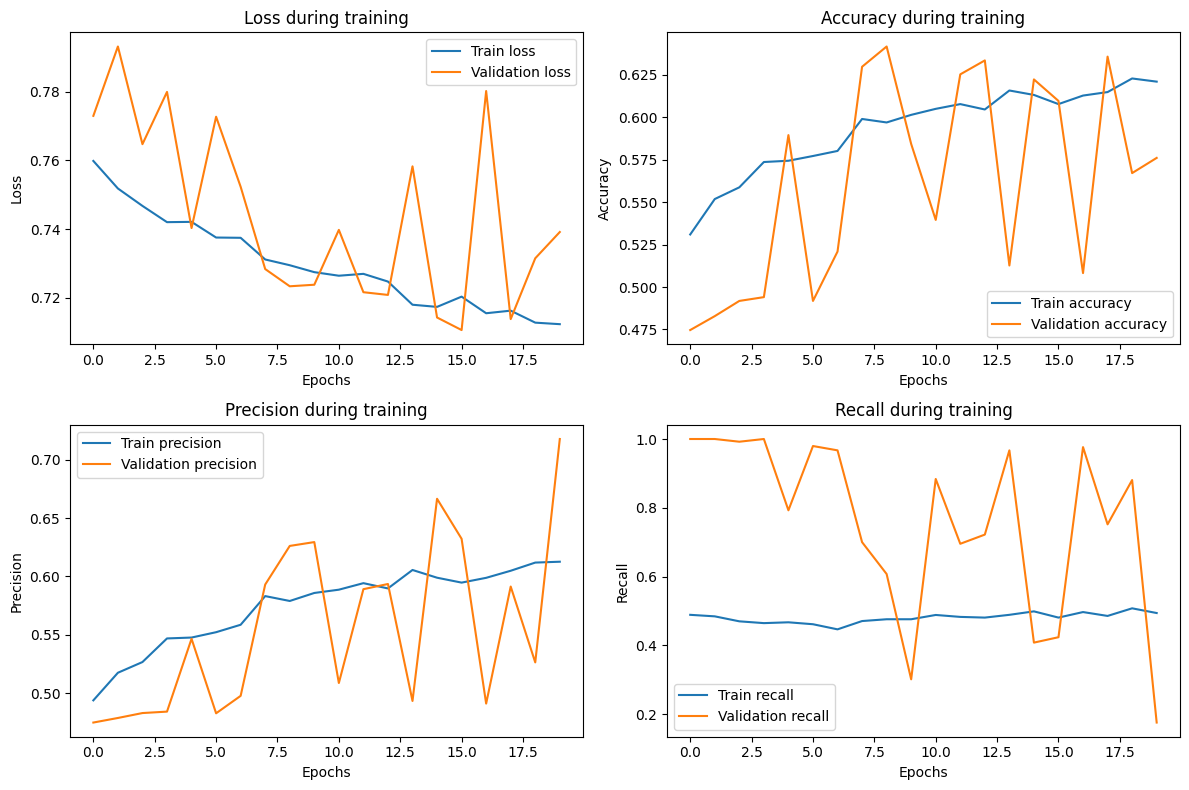

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    metrics = ['loss', 'accuracy', 'precision', 'recall', 'f1_score']
    titles = ['Loss', 'Accuracy', 'Precision', 'Recall', 'f1score']
    ylabel = ['Loss', 'Accuracy', 'Precision', 'Recall', 'f1score']

    plt.figure(figsize=(15, 12))
    for i, metric in enumerate(metrics):
        plt.subplot(3, 3, i + 1)
        plt.plot(history.history[metric], label=f'Train {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        plt.xlabel('Epochs')
        plt.ylabel(ylabel[i])
        plt.legend()
        plt.title(f'{titles[i]} during training')

    plt.tight_layout()
    plt.show()
plot_training_history(history)

Lưu model

In [ ]:
model.save('tcn.keras')